# For the comparison of different methods

In [24]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
from jax import vmap
import time

config.update("jax_enable_x64", True)
import scienceplots
plt.style.use(['science','ieee'])

Next, we update the method to have 256 spatial resolution, as to mimimise spatial errors.
We choose $dt = (10^{-5}) i$, for $i=1,...,1/16$. $T_{max} = 0.1$. 

In [26]:
key1 = jax.random.PRNGKey(0)
i=8
nmax = int(1e4 * 2**i) #10000
tmax = 0.1 # 0.1 timestep
dt = 1e-5*(1/2)**i # tmax/nmax
E=1; P=1
dW = jax.random.normal(key1, shape=(nmax, E, P))
print(dW.shape)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0, i+1):
    nmax = int(1e4 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()
#time_refine.reverse()
print(nmax,len(time_refine[0]),len(W_refine[0]))
print(len(time_refine[-1]),len(W_refine[-1]))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

array = jnp.zeros(8)
nmax = int(1e4 * 2**i) 
print(int(1e4),nmax)
tmax = 0.1 
dt = 1e-5*(1/2)**i
key = jax.random.PRNGKey(0)
for i in range(8):
    signal_params = ConfigDict(KDV_params_exact_traveling)
    signal_params.update(E=1,method='Dealiased_SETDRK4',dt= 1e-5*(1/2)**i,nt = int(1e4 * 2**i),tmax=0.1,nx=256,P=1,S=0,noise_magnitude=5, initial_condition = 'very_steep_traveling_wave')
    print(i)
    signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
    initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
    dW =(dW_refine[i]/jnp.sqrt(2**(8-i))) # renormalise. from the refined dW created.
    signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
    W = jnp.cumsum(dW, axis=0)
    W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
    W_new = jnp.zeros([signal_model.params.nt+1, signal_model.params.E, signal_model.params.P])
    W_new = W_new.at[1:,:,:].set(W)

    E = signal_model.params.E
    nmax = signal_model.params.nt
    nx = signal_model.params.nx
    x = signal_model.x
    xmax = signal_model.params.xmax
    xmin = signal_model.params.xmin
    dt = signal_model.params.dt
    
    initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))# jitted with last two arguments frozen
    def compute_ans(n, x, dt, W_new, xmax, E, initial_condition):
        return initial_condition_jitted((x - 9 * 9 * (dt * n) - W_new[n, :, :] + xmax) % (xmax * 2) - xmax, E, signal_params.initial_condition)
    
    analytic_final = compute_ans(nmax, x, dt, W_new, xmax, E, signal_params.initial_condition)
    array = array.at[i].set(relative_error_final(signal_final[-1, :], analytic_final[-1, :]))
plt.show()

(2560000, 1, 1)
2560000 10000 10000
2560000 2560000
10000 2560000
0
1
2
3
4
5
6
7


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
dt = 1e-5*np.asarray([1.,1/2,1/4,1/8,1/16,1/32,1/64,1/128])
values = array
print(values,values.shape)
a = 1e-5
v=0.02
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
plt.loglog(dt,values, marker='o', linestyle='-', color='b',label='CS-ETDRK4')

plt.loglog(dt,(dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2/a**2*v, linestyle='-', color='k', label='2 Order')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n Pathwise Temporal Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()
#plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/Temporal_convergence_2.png',bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
methods = ['Dealiased_IFSRK4','Dealiased_SETDRK4','Dealiased_SRK4']
max_number = 12
array = jnp.zeros([len(methods),max_number])
key = jax.random.PRNGKey(0)
nmax = int(1e2 * 2**max_number)
tmax = 0.01 
dt = 1e-4*(1/2)**max_number
assert dt*nmax == tmax, "dt*nmax must equal tmax for the setup to be correct."
E=1; P=1
dW = jax.random.normal(key, shape=(nmax, E, P))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0,max_number+1):
    nmax = int(1e2 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()



for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_exact_traveling)
        signal_params.update(E=1,method=method,dt= 1e-4*(1/2)**i, nt = int(1e2 * 2**i),tmax=0.01,nx=256,P=1,S=0,noise_magnitude=1, initial_condition = 'very_steep_traveling_wave')
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
        dW =(dW_refine[i]/jnp.sqrt(2**(max_number-i))) # renormalise. from the refined dW created.
        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        W = jnp.cumsum(dW, axis=0)
        W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
        W_new = jnp.zeros([signal_model.params.nt+1, signal_model.params.E, signal_model.params.P])
        W_new = W_new.at[1:,:,:].set(W)

        E = signal_model.params.E
        nmax = signal_model.params.nt
        nx = signal_model.params.nx
        x = signal_model.x
        xmax = signal_model.params.xmax
        xmin = signal_model.params.xmin
        dt = signal_model.params.dt

        initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))# jitted with last two arguments frozen
        def compute_ans(n, x, dt, W_new, xmax, E, initial_condition):
            return initial_condition_jitted((x - 9 * 9 * (dt * n) - W_new[n, :, :] + xmax) % (xmax * 2) - xmax, E, signal_params.initial_condition)

        analytic_final = compute_ans(nmax, x, dt, W_new, xmax, E, signal_params.initial_condition)
    
        array = array.at[j,i].set(relative_error_final(signal_final[-1, :], analytic_final[-1, :]))
        del signal_model

0 Dealiased_IFSRK4
1 Dealiased_IFSRK4
2 Dealiased_IFSRK4
3 Dealiased_IFSRK4
4 Dealiased_IFSRK4
5 Dealiased_IFSRK4
6 Dealiased_IFSRK4
7 Dealiased_IFSRK4
8 Dealiased_IFSRK4
9 Dealiased_IFSRK4
10 Dealiased_IFSRK4
11 Dealiased_IFSRK4
0 Dealiased_SETDRK4
1 Dealiased_SETDRK4
2 Dealiased_SETDRK4
3 Dealiased_SETDRK4
4 Dealiased_SETDRK4
5 Dealiased_SETDRK4
6 Dealiased_SETDRK4
7 Dealiased_SETDRK4
8 Dealiased_SETDRK4
9 Dealiased_SETDRK4
10 Dealiased_SETDRK4
11 Dealiased_SETDRK4
0 Dealiased_SRK4
1 Dealiased_SRK4
2 Dealiased_SRK4
3 Dealiased_SRK4
4 Dealiased_SRK4
5 Dealiased_SRK4
6 Dealiased_SRK4
7 Dealiased_SRK4
8 Dealiased_SRK4
9 Dealiased_SRK4
10 Dealiased_SRK4
11 Dealiased_SRK4


[[           nan            nan            nan            nan
  3.89895681e-02 5.28215954e-03 6.75702993e-04 8.50995475e-05
  1.06770270e-05 1.33962791e-06 1.68448560e-07 2.12246882e-08]
 [           nan 8.26283304e-01 5.85634863e-01 1.34407210e-01
  2.01512624e-02 2.65090818e-03 3.36352903e-04 4.22774924e-05
  5.30435024e-06 6.66285214e-07 8.39742897e-08 1.05993187e-08]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan 5.31372557e-10]]
(3, 12)
[[           nan            nan            nan            nan
  3.89895681e-02 5.28215954e-03 6.75702993e-04 8.50995475e-05
  1.06770270e-05 1.33962791e-06 1.68448560e-07 2.12246882e-08]
 [           nan 8.26283304e-01 5.85634863e-01 1.34407210e-01
  2.01512624e-02 2.65090818e-03 3.36352903e-04 4.22774924e-05
  5.30435024e-06 6.66285214e-07 8.39742897e-08 1.05993187e-08]
 [           nan            nan            nan          

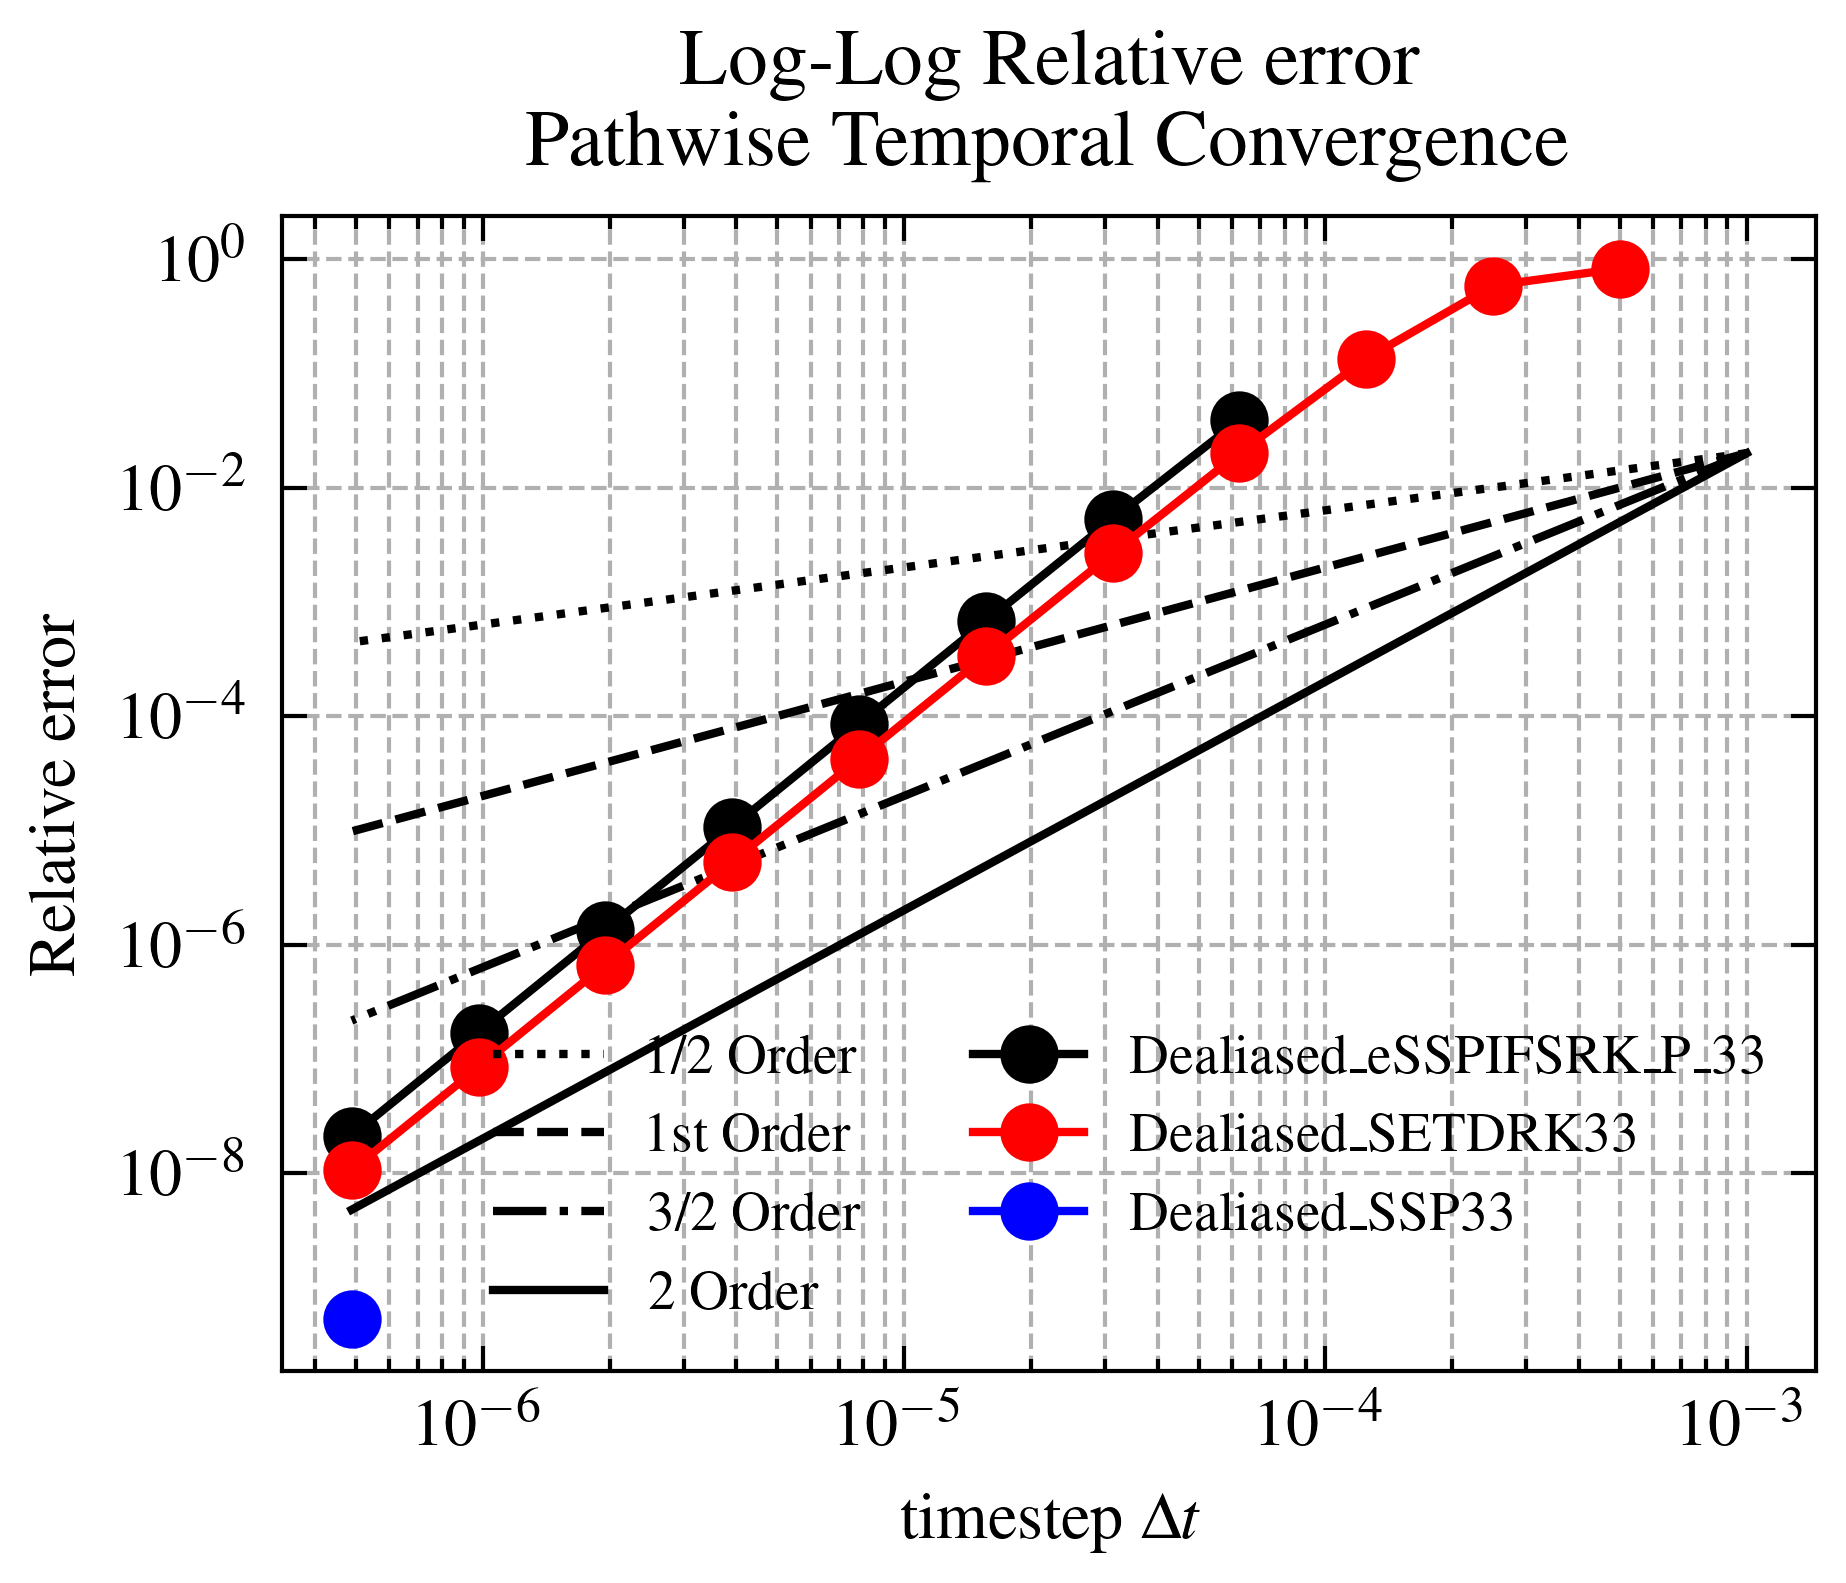

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
dt = 1e-3*np.asarray([2**-i for i in range(0,max_number)])
values = array
print(values)
print(values.shape)
values = array
print(values,values.shape)
a = 1e-3
v= 0.02
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
values = np.where(values > 1, np.nan, values)
plt.loglog(dt,(dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2/a**2*v, linestyle='-', color='k', label='2 Order')
for j,method in enumerate(methods):
    plt.loglog(dt,values[j,:], marker='o', linestyle='-',label=f'{method}')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n Pathwise Temporal Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
plt.grid(True, which="both", ls="--")

#plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/Temporal_convergence_RK4_IFRK4_ETDRK4_eSSPIFSRK_P_33.png',bbox_inches='tight',dpi=300)
plt.show()

In [21]:
methods = ['Dealiased_eSSPIFSRK_P_33','Dealiased_SETDRK33','Dealiased_SSP33']
max_number = 12
array = jnp.zeros([len(methods),max_number])
key = jax.random.PRNGKey(0)
nmax = int(1e2 * 2**max_number)
tmax = 0.1 
dt = 1e-3*(1/2)**max_number
assert dt*nmax == tmax, "dt*nmax must equal tmax for the setup to be correct."
E=1; P=1
dW = jax.random.normal(key, shape=(nmax, E, P))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0,max_number+1):
    nmax = int(1e2 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()



for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_exact_traveling)
        signal_params.update(E=1,method=method,dt= 1e-3*(1/2)**i, nt = int(1e2 * 2**i),tmax=0.1,nx=256,P=1,S=0,noise_magnitude=0.01, initial_condition = 'very_steep_traveling_wave')
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
        dW =(dW_refine[i]/jnp.sqrt(2**(max_number-i))) # renormalise. from the refined dW created.
        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        W = jnp.cumsum(dW, axis=0)
        W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
        W_new = jnp.zeros([signal_model.params.nt+1, signal_model.params.E, signal_model.params.P])
        W_new = W_new.at[1:,:,:].set(W)

        E = signal_model.params.E
        nmax = signal_model.params.nt
        nx = signal_model.params.nx
        x = signal_model.x
        xmax = signal_model.params.xmax
        xmin = signal_model.params.xmin
        dt = signal_model.params.dt

        initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))# jitted with last two arguments frozen
        def compute_ans(n, x, dt, W_new, xmax, E, initial_condition):
            return initial_condition_jitted((x - 9 * 9 * (dt * n) - W_new[n, :, :] + xmax) % (xmax * 2) - xmax, E, signal_params.initial_condition)

        analytic_final = compute_ans(nmax, x, dt, W_new, xmax, E, signal_params.initial_condition)
    
        array = array.at[j,i].set(relative_error_final(signal_final[-1, :], analytic_final[-1, :]))
        del signal_model

0 Dealiased_eSSPIFSRK_P_33
1 Dealiased_eSSPIFSRK_P_33
2 Dealiased_eSSPIFSRK_P_33
3 Dealiased_eSSPIFSRK_P_33
4 Dealiased_eSSPIFSRK_P_33
5 Dealiased_eSSPIFSRK_P_33
6 Dealiased_eSSPIFSRK_P_33
7 Dealiased_eSSPIFSRK_P_33
8 Dealiased_eSSPIFSRK_P_33
9 Dealiased_eSSPIFSRK_P_33
10 Dealiased_eSSPIFSRK_P_33
11 Dealiased_eSSPIFSRK_P_33
0 Dealiased_SETDRK33
1 Dealiased_SETDRK33
2 Dealiased_SETDRK33
3 Dealiased_SETDRK33
4 Dealiased_SETDRK33
5 Dealiased_SETDRK33
6 Dealiased_SETDRK33
7 Dealiased_SETDRK33
8 Dealiased_SETDRK33
9 Dealiased_SETDRK33
10 Dealiased_SETDRK33
11 Dealiased_SETDRK33
0 Dealiased_SSP33
1 Dealiased_SSP33
2 Dealiased_SSP33
3 Dealiased_SSP33
4 Dealiased_SSP33
5 Dealiased_SSP33
6 Dealiased_SSP33
7 Dealiased_SSP33
8 Dealiased_SSP33
9 Dealiased_SSP33
10 Dealiased_SSP33
11 Dealiased_SSP33


[[           nan            nan            nan            nan
  3.89895681e-02 5.28215954e-03 6.75702993e-04 8.50995475e-05
  1.06770270e-05 1.33962791e-06 1.68448560e-07 2.12246882e-08]
 [           nan 8.26283304e-01 5.85634863e-01 1.34407210e-01
  2.01512624e-02 2.65090818e-03 3.36352903e-04 4.22774924e-05
  5.30435024e-06 6.66285214e-07 8.39742897e-08 1.05993187e-08]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan 5.31372557e-10]]
(3, 12)
[[           nan            nan            nan            nan
  3.89895681e-02 5.28215954e-03 6.75702993e-04 8.50995475e-05
  1.06770270e-05 1.33962791e-06 1.68448560e-07 2.12246882e-08]
 [           nan 8.26283304e-01 5.85634863e-01 1.34407210e-01
  2.01512624e-02 2.65090818e-03 3.36352903e-04 4.22774924e-05
  5.30435024e-06 6.66285214e-07 8.39742897e-08 1.05993187e-08]
 [           nan            nan            nan          

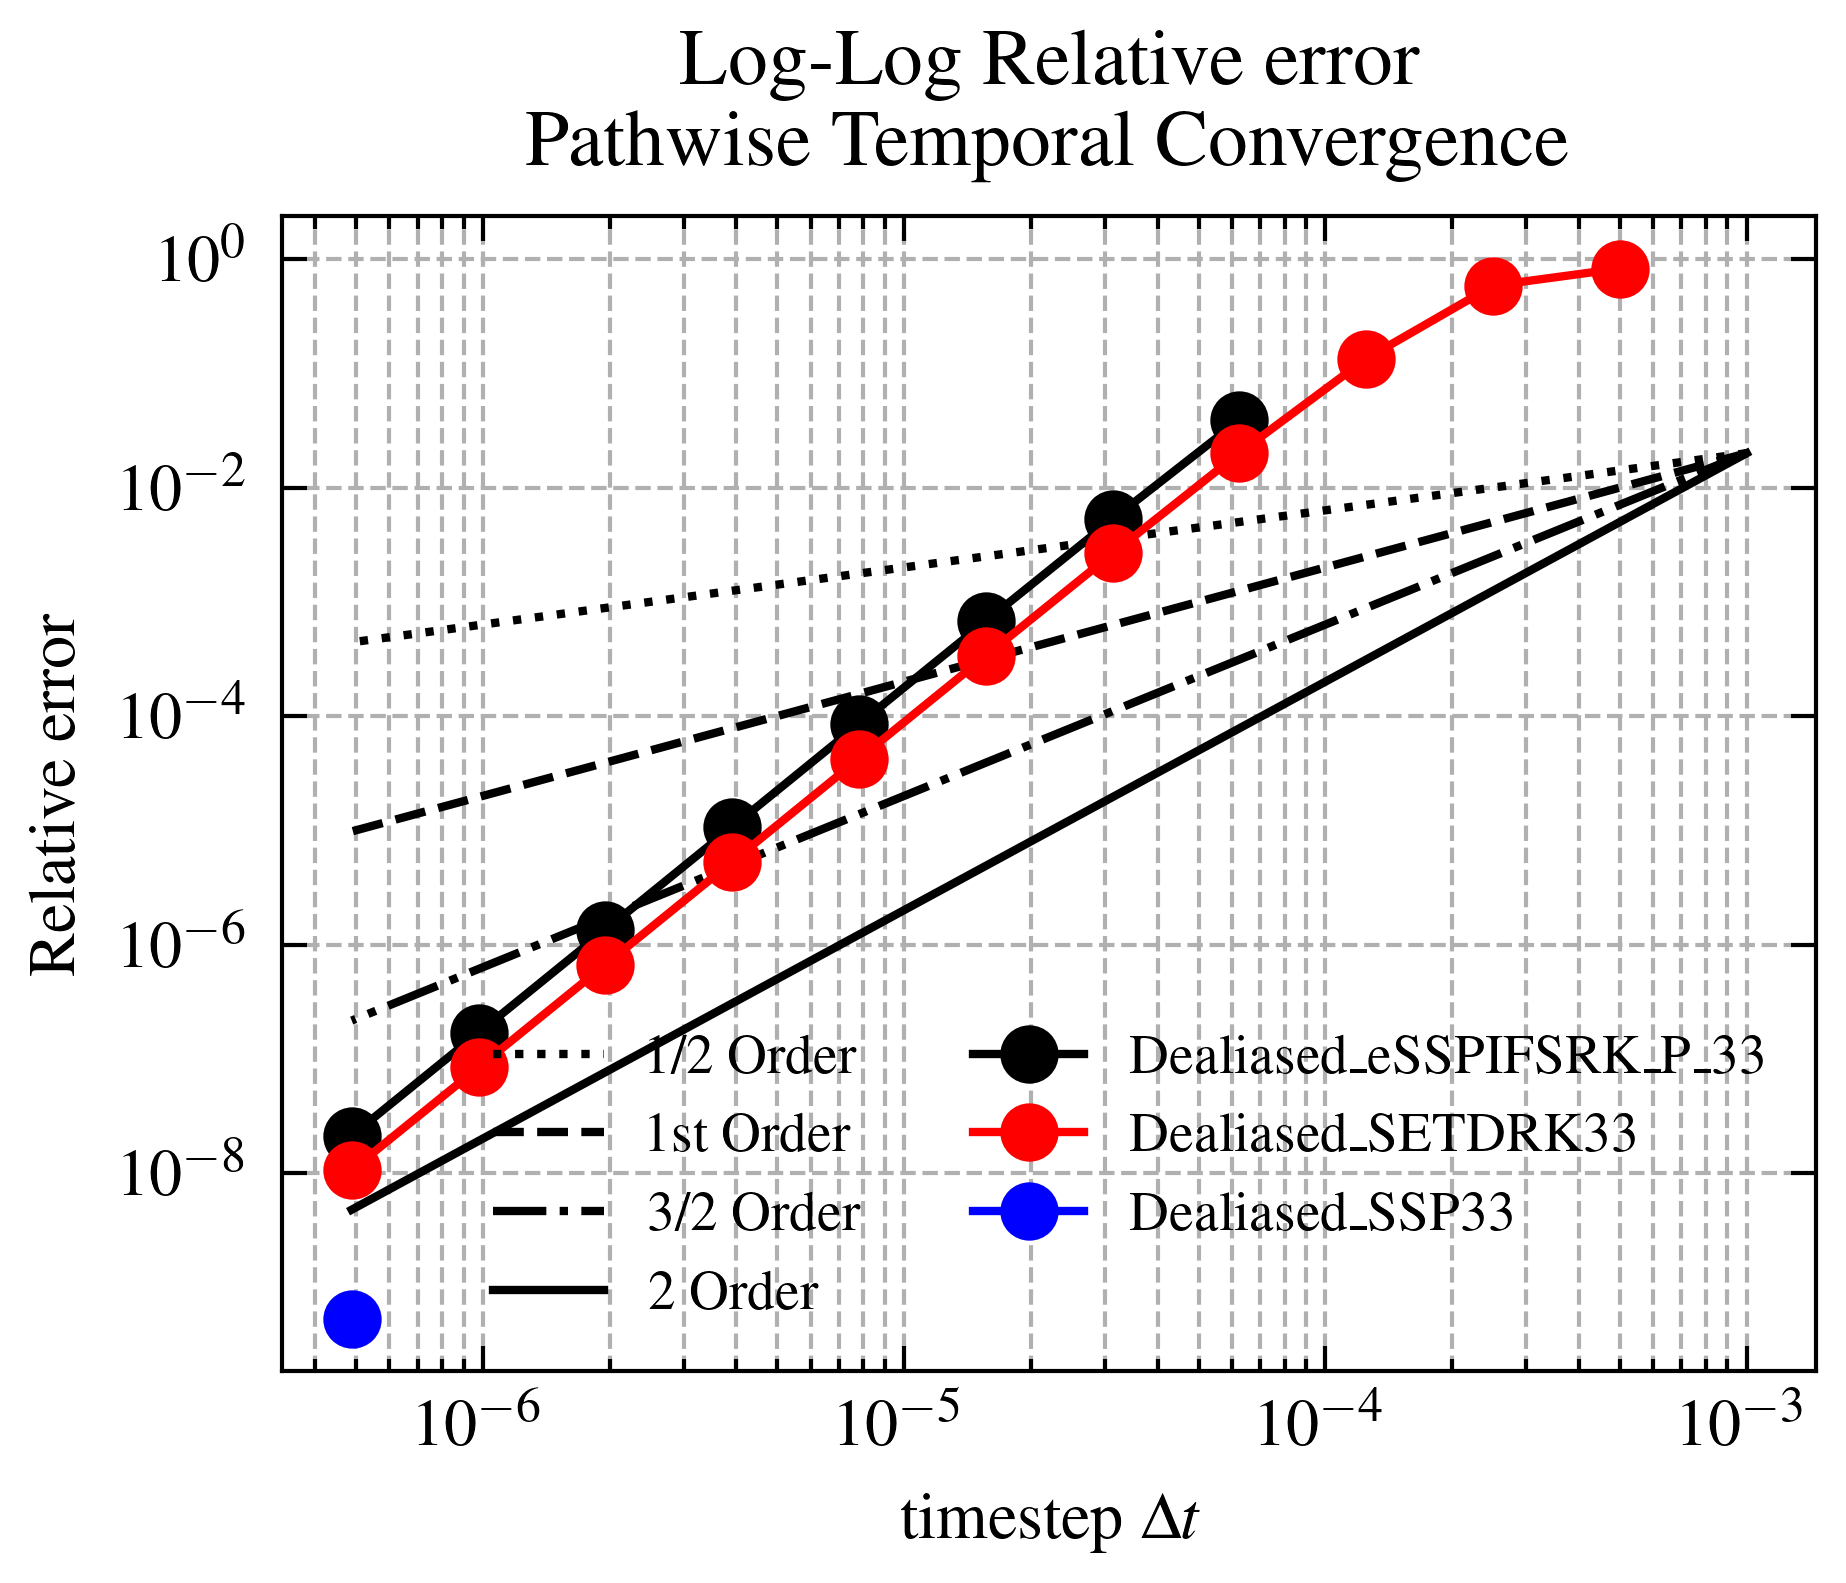

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
dt = 1e-3*np.asarray([2**-i for i in range(0,max_number)])
values = array
print(values)
print(values.shape)
values = array
print(values,values.shape)
a = 1e-3
v= 0.02
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
values = np.where(values > 1, np.nan, values)
plt.loglog(dt,(dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2/a**2*v, linestyle='-', color='k', label='2 Order')
for j,method in enumerate(methods):
    plt.loglog(dt,values[j,:], marker='o', linestyle='-',label=f'{method}')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n Pathwise Temporal Convergence')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
plt.grid(True, which="both", ls="--")

#plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/Temporal_convergence_RK4_IFRK4_ETDRK4_eSSPIFSRK_P_33.png',bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
from models.ETD_KT_CM_JAX_Vectorised import *
signal_params = ConfigDict(KDV_params_exact_traveling)
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)

print(signal_model.print_timestepping_methods())
methods = ['Dealiased_SETDRK4', 'Dealiased_SETDRK33', 'Dealiased_IFSRK4', 'Dealiased_eSSPIFSRK_P_33', 'Dealiased_SRK4', 'Dealiased_SSP33']
max_number = 8
del signal_model
array = jnp.zeros([len(methods),max_number])


key1 = jax.random.PRNGKey(0)
i=10
nmax = int(1e3 * 2**i) #1000
tmax = 0.001 # 1e-3 timestep
dt = 1e-6*(1/2)**i # tmax/nmax
E=1; P=1
dW = jax.random.normal(key1, shape=(nmax, E, P))
print(dW.shape)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0, i+1):
    nmax = int(1e3 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()
#time_refine.reverse()
print(nmax,len(time_refine[0]),len(W_refine[0]))
print(len(time_refine[-1]),len(W_refine[-1]))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)


for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_exact_traveling)
        signal_params.update(E=1,method=method,dt= 1e-6*(1/2)**i,nt = int(1e3 * 2**i),tmax=0.001,nx=256,P=1,S=0,noise_magnitude=1, initial_condition = 'very_steep_traveling_wave')
        print(i)
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)

        dW =(dW_refine[i]/jnp.sqrt(2**(8-i))) # renormalise. from the refined dW created.
        start_time = time.time()

        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        end_time = time.time()
        print(f"Elapsed time for numerical i={i}: {end_time - start_time:.4f} seconds")
        W = jnp.cumsum(dW, axis=0)
        W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
        W_new = jnp.zeros([signal_model.params.nt+1, signal_model.params.E, signal_model.params.P])
        W_new = W_new.at[1:,:,:].set(W)

        E = signal_model.params.E
        nmax = signal_model.params.nt
        nx = signal_model.params.nx
        x = signal_model.x
        xmax = signal_model.params.xmax
        xmin = signal_model.params.xmin
        dt = signal_model.params.dt


        start_time = time.time()
        initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))# jitted with last two arguments frozen
        def compute_ans(n, x, dt, W_new, xmax, E, initial_condition):
            return initial_condition_jitted((x - 9 * 9 * (dt * n) - W_new[n, :, :] + xmax) % (xmax * 2) - xmax, E, signal_params.initial_condition)

        analytic_final = compute_ans(nmax, x, dt, W_new, xmax, E, signal_params.initial_condition)
        end_time = time.time()
        print(f"Elapsed time for Analytic i={i}: {end_time - start_time:.4f} seconds")
        # print(analytic_final.shape, signal_final.shape)

        # plt.figure(figsize=(10, 5))
        # plt.plot(x, signal_final[0, :] - analytic_final[0, :], label='Numerical - Analytic')
        # plt.xlabel('Space')
        # plt.ylabel('Difference')
        # plt.title('Difference between Numerical and Analytic Final Solutions')
        # plt.legend()
        # plt.show()
        #array = array.at[i].set(relative_error_final(signal_final[-1, :], analytic_final[-1, :]))
        array = array.at[j,i].set(relative_error_final(signal_final[-1, :], analytic_final[-1, :]))
        del signal_model

In [ ]:
import scienceplots
import numpy as np
plt.style.use(['science','ieee'])

# Define marker and color lists for cycling
marker_list = ['o', 's', 'D', '^', 'v', 'x', '+', '*', 'p', 'H', 'd', 'X']
color_list = ['b', 'g', 'r', 'm', 'c', 'y', 'orange', 'purple', 'brown', 'teal', 'olive', 'gray']

# Assign colors based on method order (4, 3, 2, etc.)
order_map = {
    4: 'b',
    3: 'g',
    2: 'r',
    1: 'm'
}
def get_order(method):
    if 'RK4' in method or '4' in method:
        return 4
    elif '33' in method or '3' in method:
        return 3
    elif '22' in method or '2' in method:
        return 2
    elif '11' in method or '1' in method:
        return 1
    else:
        return 0

for j, method in enumerate(methods):
    color = order_map.get(get_order(method), color_list[j % len(color_list)])
    marker = marker_list[j % len(marker_list)]
    plt.loglog(dt, values[j, :], marker=marker, linestyle='-', color=color, label=f'{method.replace("Dealiased_", "")}', markerfacecolor='none')
max_number = 8
dt = 1e-6 * np.asarray([2**-i for i in range(0, max_number)])
a = 1e-6
v=1e-5
# plt.figure()
plt.loglog(dt, (dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt, dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt, (dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt, dt**2/a**2*v, linestyle='-', color='k', label='2 Order')

# for j, method in enumerate(methods):
#     plt.loglog(dt, values[j, :], label=f'{method.replace("Dealiased_", "")}')

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n Pathwise Temporal Convergence')
plt.grid(True, which="both", ls="--")
plt.legend(fontsize='small', loc='best', ncol=2)
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

dt = 1e-6*np.asarray([2**-i for i in range(0,max_number)])
values = array
print(values)
print(values.shape)
values = array
print(values,values.shape)
a = 1e-5
v=0.02
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')

plt.loglog(dt,(dt**0.5)/a**0.5*v, linestyle=':', color='k', label=r'1/2 Order')
plt.loglog(dt,dt/a*v, linestyle='--', color='k', label='1st Order')
plt.loglog(dt,(dt**1.5)/a**1.5*v, linestyle='-.', color='k', label='3/2 Order')
plt.loglog(dt,dt**2/a**2*v, linestyle='-', color='k', label='2 Order')
for j,method in enumerate(methods):

    if "1" in method or "2" in method or "EM" in method:
        continue

    # Mask values greater than 1 before plotting

    if method.startswith("Dealiased_SETD"):
        color = 'b'
        if method == "Dealiased_SETDRK4":
            marker = 'o'
            linestyle = '-'
        elif method == "Dealiased_SETDRK33":
            marker = '+'
            linestyle = '--'
        elif method == "Dealiased_SETDRK22":
            marker = '^'
            linestyle = '-.'
        elif method == "Dealiased_SETDRK11":
            marker = 'd'
            linestyle = ':'
        plt.loglog(dt, values[j, :], marker=marker, linestyle=linestyle, color=color, label=f'{method.replace("Dealiased_", "")}',markerfacecolor='none')
            # Add a small offset to the marker positions to avoid overlap
        # plt.loglog(dt,values[j, :], marker=marker, linestyle=linestyle, color=color, label=f'{method.replace("Dealiased_", "")}')
        #plt.loglog(dt, values[j, :], marker=marker, linestyle=linestyle, color=color, label=f'{method.replace("Dealiased_", "")}')
        # plt.loglog(dt, values[j, :], marker='o', linestyle='-', color=color, label=f'{method.replace("Dealiased_", "")}')

    if method in ['Dealiased_SRK4', 'Dealiased_SSP33', 'Dealiased_SSP22', 'Dealiased_EM']:
        color = 'g'
        if method == 'Dealiased_SRK4':
            marker = 's'
            linestyle = '-'
        elif method == 'Dealiased_SSP33':
            marker = 'x'
            linestyle = '--'
        elif method == 'Dealiased_SSP22':
            marker = '*'
            linestyle = '-.'
        elif method == 'Dealiased_EM':
            marker = 'v'
            linestyle = ':'
        plt.loglog(dt, values[j, :], marker=marker, linestyle=linestyle, color=color, label=f'{method.replace("Dealiased_", "")}',markerfacecolor='none')

    if method in ['Dealiased_IFSRK4', 'Dealiased_eSSPIFSRK_P_33', 'Dealiased_eSSPIFSRK_P_22', 'Dealiased_eSSPIFSRK_P_11']:
        color = 'r'
        if method == 'Dealiased_IFSRK4':
            marker = 'D'
            linestyle = '-'
        elif method == 'Dealiased_eSSPIFSRK_P_33':
            marker = 'H'
            linestyle = '--'
        elif method == 'Dealiased_eSSPIFSRK_P_22':
            marker = 'p'
            linestyle = '-.'
        elif method == 'Dealiased_eSSPIFSRK_P_11':
            marker = 'X'
            linestyle = ':'
        masked_values = np.where(values[j, :] > 0.1, np.nan, values[j, :])

        plt.loglog(dt, masked_values[ :], marker=marker, linestyle=linestyle, color=color, label=f'{method.replace("Dealiased_", "")}',markerfacecolor='none')
    else:
        color = None

plt.xlabel(r'timestep $\Delta t$')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n Pathwise Temporal Convergence')
#plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")

#plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/Temporal_convergence_RK4_IFRK4_ETDRK4_eSSPIFSRK_P_33.png',bbox_inches='tight',dpi=300)
plt.show()